<a href="https://colab.research.google.com/github/yeonmi02/mlproject/blob/main/mlproject_trafficdata_XGBoost_LightGBM_Prophet_RandomForest_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 데이터 불러오기

In [100]:
# 관련 라이브러리 임포트하고 데이터 불러오기
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from prophet import Prophet
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

traffic_2 = pd.read_csv('/content/drive/MyDrive/TrafficTwoMonth.csv')
traffic_2.head(10)

,Time,Date,Day of the week,CarCount,BikeCount,BusCount,TruckCount,Total,Traffic Situation
0,12:00:00 AM,10,Tuesday,13,2,2,24,41,normal
1,12:15:00 AM,10,Tuesday,14,1,1,36,52,normal
2,12:30:00 AM,10,Tuesday,10,2,2,32,46,normal
3,12:45:00 AM,10,Tuesday,10,2,2,36,50,normal
4,1:00:00 AM,10,Tuesday,11,2,1,34,48,normal
5,1:15:00 AM,10,Tuesday,15,1,1,39,56,normal
6,1:30:00 AM,10,Tuesday,14,2,2,27,45,normal
7,1:45:00 AM,10,Tuesday,13,2,1,20,36,normal
8,2:00:00 AM,10,Tuesday,7,0,0,26,33,normal
9,2:15:00 AM,10,Tuesday,13,0,0,34,47,normal


In [101]:
import numpy as np

# 시간 데이터를 datatime으로 변환
traffic_2['Datetime'] = pd.to_datetime(traffic_2['Date'].astype(str) + ' ' + traffic_2['Time'], format='%d %I:%M:%S %p', errors='coerce')

In [102]:
# 예측에 필요하지 않은 예측을 제거하는 코드
traffic_2.drop(columns=['Time', 'Date'], inplace=True)

In [103]:
# 데이터 중 범주형 데이터들을 인코딩하는 코드
traffic_2['Day of the week'] = traffic_2['Day of the week'].astype('category')
traffic_2['Traffic Situation'] = traffic_2['Traffic Situation'].astype('category')

In [104]:
# 원핫인코딩이 필요한 칼럼 원핫인코딩하는 코드
traffic_2 = pd.get_dummies(traffic_2, columns=['Day of the week', 'Traffic Situation'])

In [105]:
# 데이터 결측치 처리하는 코드
traffic_2 = traffic_2.dropna(subset=['Datetime'])

In [106]:
# 전처리한 특성들을 정리해보는 코드
cols = ['Datetime'] + [col for col in traffic_2.columns if col != 'Datetime']
traffic_2 = traffic_2[cols]

In [107]:
# 모든 전처리가 저장된 데이터를 다시 출력해보는 코드
traffic_2.to_csv('/content/ProcessedTraffic.csv', index=False)
traffic_2.head()

,Datetime,CarCount,BikeCount,BusCount,TruckCount,Total,Day of the week_Friday,Day of the week_Monday,Day of the week_Saturday,Day of the week_Sunday,Day of the week_Thursday,Day of the week_Tuesday,Day of the week_Wednesday,Traffic Situation_heavy,Traffic Situation_high,Traffic Situation_low,Traffic Situation_normal
0,1900-01-10 00:00:00,13,2,2,24,41,False,False,False,False,False,True,False,False,False,False,True
1,1900-01-10 00:15:00,14,1,1,36,52,False,False,False,False,False,True,False,False,False,False,True
2,1900-01-10 00:30:00,10,2,2,32,46,False,False,False,False,False,True,False,False,False,False,True
3,1900-01-10 00:45:00,10,2,2,36,50,False,False,False,False,False,True,False,False,False,False,True
4,1900-01-10 01:00:00,11,2,1,34,48,False,False,False,False,False,True,False,False,False,False,True


In [108]:
# 특성 중 수치형 확인하는 코드
numeric_cols = ['CarCount', 'BikeCount', 'BusCount', 'TruckCount', 'Total']

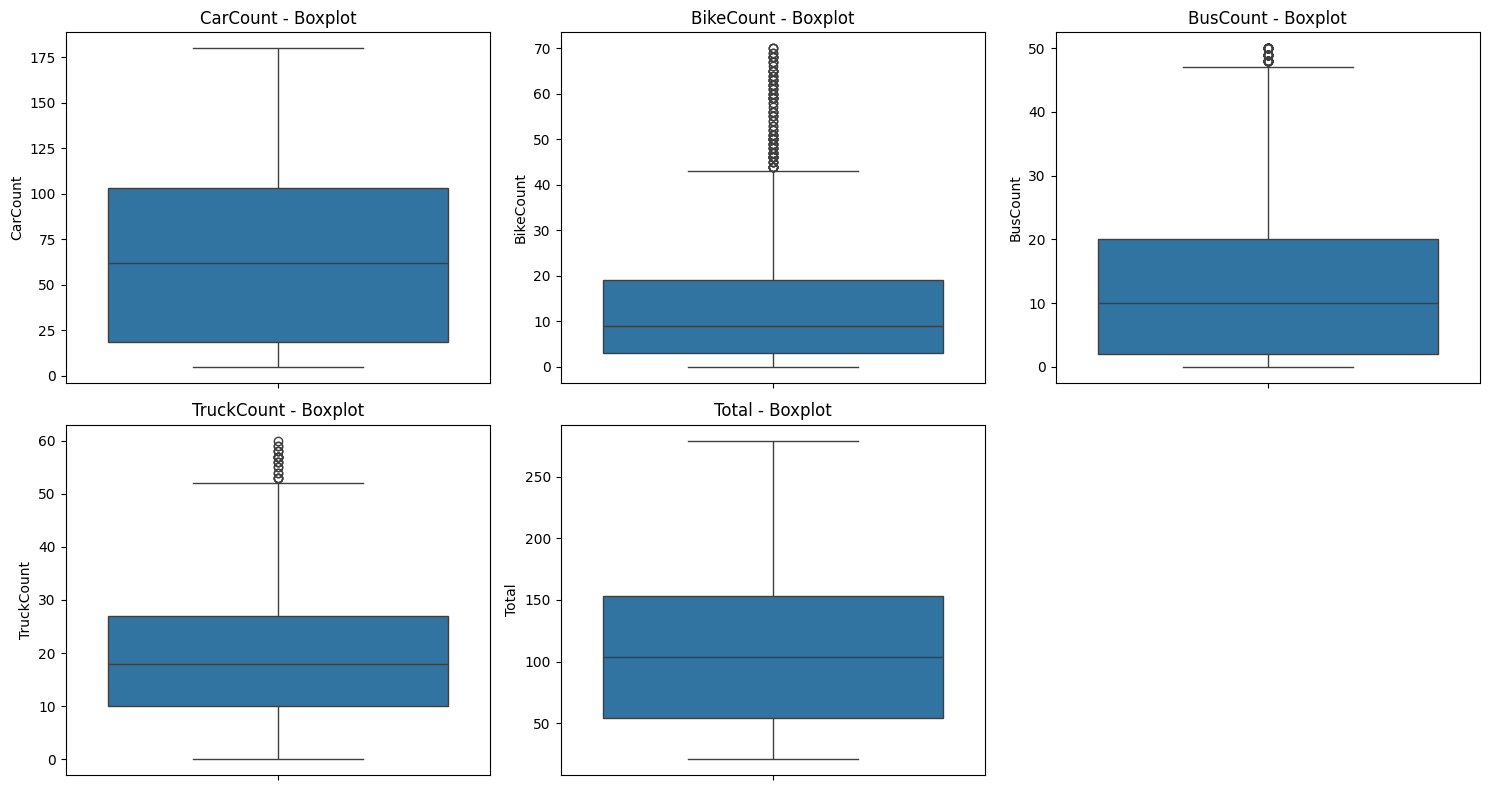

In [109]:
# 데이터 중 이상치 탐지하는 코드
plt.figure(figsize=(15, 8))
for i, col in enumerate(numeric_cols, 1):
    plt.subplot(2, 3, i)
    sns.boxplot(y=traffic_2[col])
    plt.title(f'{col} - Boxplot')
plt.tight_layout()
plt.show()

In [110]:
# 시간 데이터를 처리하는 코드
traffic_2['Datetime'] = pd.to_datetime(traffic_2['Datetime'])
traffic_2.set_index('Datetime', inplace=True)

In [111]:
# 수치형 특성을 30분 간격으로 다시 생성해서 평균을 구하는 코드
numeric_cols = ['CarCount', 'BikeCount', 'BusCount', 'TruckCount', 'Total']
traffic_2_num = traffic_2[numeric_cols].resample('30T').mean()

<ipython-input-111-04e4b49b837c>:3: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  traffic_2_num = traffic_2[numeric_cols].resample('30T').mean()


In [112]:
# 모든 특성을 출력
print(traffic_2.columns.tolist())

['CarCount', 'BikeCount', 'BusCount', 'TruckCount', 'Total', 'Day of the week_Friday', 'Day of the week_Monday', 'Day of the week_Saturday', 'Day of the week_Sunday', 'Day of the week_Thursday', 'Day of the week_Tuesday', 'Day of the week_Wednesday', 'Traffic Situation_heavy', 'Traffic Situation_high', 'Traffic Situation_low', 'Traffic Situation_normal']


In [113]:
# 범주형 특성들도 30분 간격으로 다시 만들면서 최빈값을 구하는 코드
categorical_cols = [ 'Day of the week_Friday', 'Day of the week_Monday', 'Day of the week_Saturday', 'Day of the week_Sunday', 'Day of the week_Thursday', 'Day of the week_Tuesday', 'Day of the week_Wednesday', 'Traffic Situation_heavy', 'Traffic Situation_high', 'Traffic Situation_low', 'Traffic Situation_normal']
def mode_agg(x):
    return x.mode()[0] if not x.mode().empty else np.nan
traffic_2_cat = traffic_2[categorical_cols].resample('30T').agg(mode_agg)

<ipython-input-113-fd727b734157>:5: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  traffic_2_cat = traffic_2[categorical_cols].resample('30T').agg(mode_agg)


In [114]:
# 30분 단위로 재생성된 수치형,범주형 특성을 하나로 합치는 코드
traffic_2_30min = pd.concat([traffic_2_num, traffic_2_cat], axis=1).reset_index()

In [115]:
# 새로 생성된 데이터를 10개 출력해보는 코드
print(traffic_2_30min.head(10))

             Datetime  CarCount  BikeCount  BusCount  TruckCount   Total  \
0 1900-01-01 00:00:00     13.75       2.00      0.25       31.50   47.50   
1 1900-01-01 00:30:00     15.50       1.75      0.75       25.25   43.25   
2 1900-01-01 01:00:00     11.50       1.50      0.50       29.25   42.75   
3 1900-01-01 01:30:00     15.25       1.75      1.00       19.75   37.75   
4 1900-01-01 02:00:00     13.00       2.00      0.50       27.25   42.75   
5 1900-01-01 02:30:00      9.50       0.50      0.50       29.50   40.00   
6 1900-01-01 03:00:00     13.75       2.75      1.00       31.25   48.75   
7 1900-01-01 03:30:00     13.00       2.00      0.50       25.00   40.50   
8 1900-01-01 04:00:00     57.50       8.50      3.00       12.00   81.00   
9 1900-01-01 04:30:00     75.75      13.25      4.00       21.75  114.75   

   Day of the week_Friday  Day of the week_Monday  Day of the week_Saturday  \
0                   False                   False                     False   
1    

In [116]:
# datetime 특성에서 서로 간 차이를 계산하고 각 시간 차이가 몇 번 나타나는지를 나타내는 코드
print(traffic_2_30min['Datetime'].diff().value_counts())

Datetime
0 days 00:30:00    1487
Name: count, dtype: int64


In [117]:
# 전처리 전과 후의 데이터 개수 확인
print(f"원본 데이터 개수: {len(traffic_2)}")
print(f"30분 단위 데이터 개수: {len(traffic_2_30min)}")

원본 데이터 개수: 5952
30분 단위 데이터 개수: 1488


In [118]:
# 시각화를 위한 준비 코드
plt.figure(figsize=(14, 6))
vehicle_cols = ['CarCount', 'BikeCount', 'BusCount', 'TruckCount']

<Figure size 1400x600 with 0 Axes>

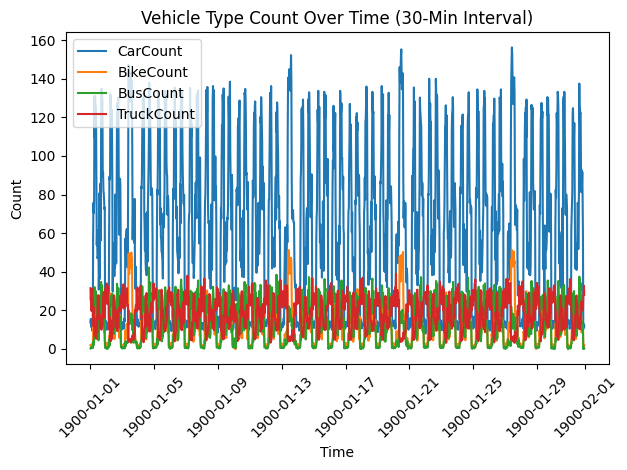

In [119]:
# 차량 종류 별로 교통량을 시각화하는 코드
for col in vehicle_cols:
    sns.lineplot(data=traffic_2_30min, x='Datetime', y=col, label=col)

plt.title('Vehicle Type Count Over Time (30-Min Interval)')
plt.xlabel('Time')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

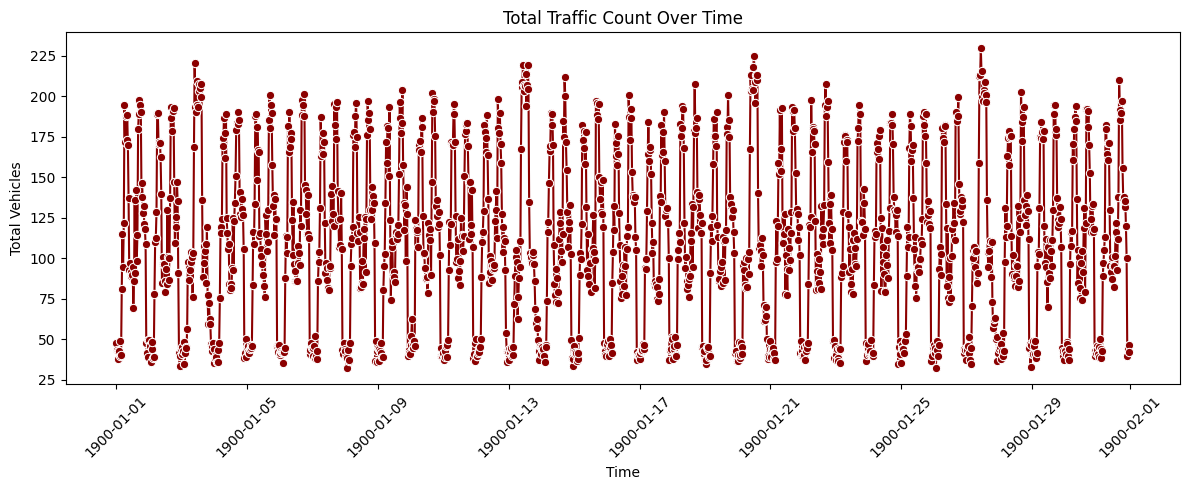

In [120]:
# 전체 교통량을 시간 순으로 나타내는 코드
plt.figure(figsize=(12, 5))
sns.lineplot(data=traffic_2_30min, x='Datetime', y='Total', color='darkred', marker='o')
plt.title('Total Traffic Count Over Time')
plt.xlabel('Time')
plt.ylabel('Total Vehicles')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

<ipython-input-121-acc9fcd6bf99>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=traffic_2_30min, x='weekday', y='Total', estimator='mean', order=[


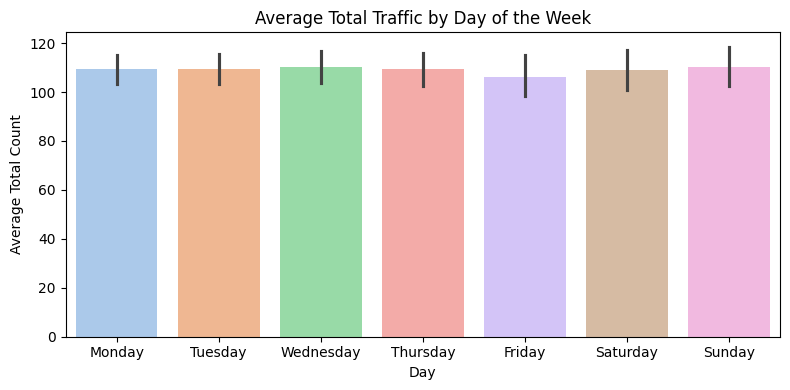

In [121]:
# 요일별 전체 교통량을 나타내는 코드
weekday_cols = [
    'Day of the week_Monday', 'Day of the week_Tuesday', 'Day of the week_Wednesday',
    'Day of the week_Thursday', 'Day of the week_Friday',
    'Day of the week_Saturday', 'Day of the week_Sunday'
]

traffic_2_30min['weekday'] = traffic_2_30min[weekday_cols].idxmax(axis=1).str.replace('Day of the week_', '')

plt.figure(figsize=(8, 4))
sns.barplot(data=traffic_2_30min, x='weekday', y='Total', estimator='mean', order=[
    'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'
], palette='pastel')
plt.title('Average Total Traffic by Day of the Week')
plt.xlabel('Day')
plt.ylabel('Average Total Count')
plt.tight_layout()
plt.show()

<ipython-input-122-28f3c192934a>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=traffic_2_30min, x='traffic_level', y='Total', palette='Set2',


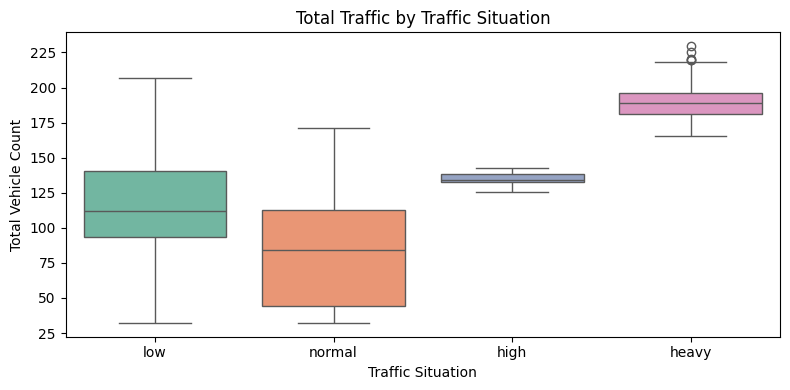

In [122]:
# 교통 상황별로 전체 차량 수를 나타내는 코
traffic_cols = [
    'Traffic Situation_low', 'Traffic Situation_normal',
    'Traffic Situation_high', 'Traffic Situation_heavy'
]

traffic_2_30min['traffic_level'] = traffic_2_30min[traffic_cols].idxmax(axis=1).str.replace('Traffic Situation_', '')

plt.figure(figsize=(8, 4))
sns.boxplot(data=traffic_2_30min, x='traffic_level', y='Total', palette='Set2',
            order=['low', 'normal', 'high', 'heavy'])
plt.title('Total Traffic by Traffic Situation')
plt.xlabel('Traffic Situation')
plt.ylabel('Total Vehicle Count')
plt.tight_layout()
plt.show()

# XGBoost 모델 구현하기

In [123]:
# xgboost 모델을 구현하기 위한 라이브러리 임포트하기
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt

In [124]:
# 입력용 특성 생성하는 코드
feature_cols = [
    'CarCount', 'BikeCount', 'BusCount', 'TruckCount',
    'Day of the week_Monday', 'Day of the week_Tuesday', 'Day of the week_Wednesday',
    'Day of the week_Thursday', 'Day of the week_Friday', 'Day of the week_Saturday',
    'Day of the week_Sunday'
]

X = traffic_2[feature_cols]

In [125]:
# 특성 중에 교통 상황 레벨을 타겟 데이터로 설정하는 코드
traffic_cols = [
    'Traffic Situation_low', 'Traffic Situation_normal',
    'Traffic Situation_high', 'Traffic Situation_heavy'
]

traffic_2['traffic_level'] = traffic_2[traffic_cols].idxmax(axis=1).str.replace('Traffic Situation_', '')

y = traffic_2['traffic_level']

In [126]:
# 레이블 인코딩과 데이터 셋을 나누는 코드
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_encoded = le.fit_transform(y)

X_train, X_val, y_train, y_val = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

In [127]:
# xgboost 모델을 생성하고 학습하는 코드
xgb_model = xgb.XGBClassifier(
    objective='multi:softprob',
    num_class=len(le.classes_),
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    random_state=42
)

xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None, num_class=4,
              num_parallel_tree=None, ...)

In [128]:
# 학습된 xgboost 모델의 검증데이터를 평가하는 코드
y_pred = xgb_model.predict(X_val)
acc = accuracy_score(y_val, y_pred)
print(f'Validation Accuracy: {acc:.3f}')
print('\nClassification Report:\n', classification_report(y_val, y_pred, target_names=le.classes_))

Validation Accuracy: 0.966

Classification Report:
               precision    recall  f1-score   support

       heavy       0.96      0.95      0.95       228
        high       0.87      0.89      0.88        74
         low       0.95      0.98      0.96       167
      normal       0.98      0.98      0.98       722

    accuracy                           0.97      1191
   macro avg       0.94      0.95      0.94      1191
weighted avg       0.97      0.97      0.97      1191



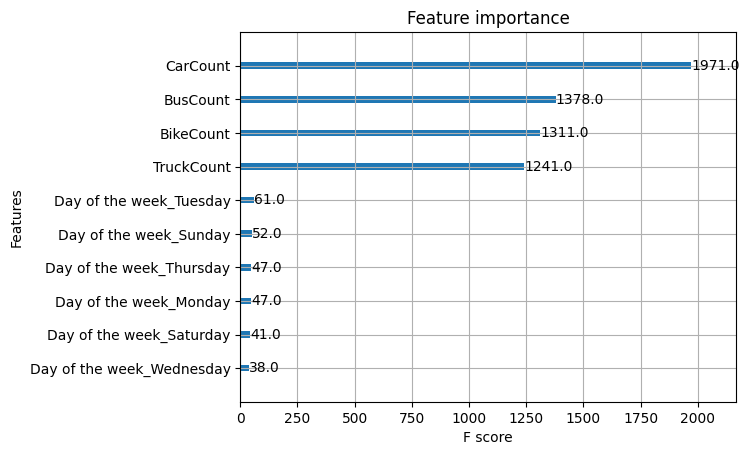

In [129]:
# 학습된 xgboost 모델의 특성 중요도 보여주는 코드
xgb.plot_importance(xgb_model, max_num_features=10)
plt.show()

In [130]:
# 라이브러리 임포트
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [131]:
# 학습된 모델을 바탕으로 예측하고 정확도를 출력하는 코드
y_pred = xgb_model.predict(X_val)

acc = accuracy_score(y_val, y_pred)
print(f'Validation Accuracy: {acc:.3f}')

Validation Accuracy: 0.966


In [132]:
# 검증 데이터에 대한 분류 성능을 출력하는 코드
print('\nClassification Report:')
print(classification_report(y_val, y_pred, target_names=le.classes_))


Classification Report:
              precision    recall  f1-score   support

       heavy       0.96      0.95      0.95       228
        high       0.87      0.89      0.88        74
         low       0.95      0.98      0.96       167
      normal       0.98      0.98      0.98       722

    accuracy                           0.97      1191
   macro avg       0.94      0.95      0.94      1191
weighted avg       0.97      0.97      0.97      1191



## 혼동행렬 : 모델이 예측한 결과와 실제 정답을 비교해 분류 성능을 자세히 보여주는 2차원 형태의 표이다.

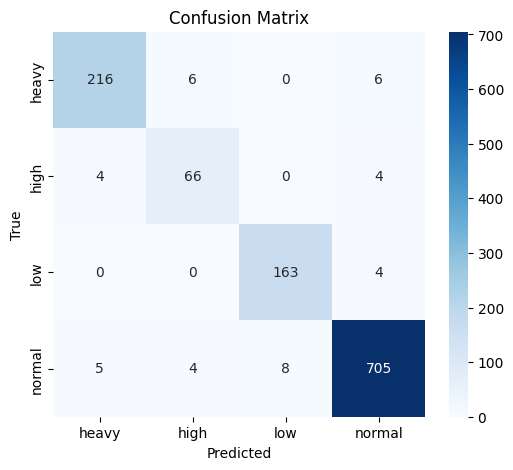

In [133]:
# 검증 데이터에 대한 혼동행렬을 계산하고 시각화하는 코드
cm = confusion_matrix(y_val, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_,
            yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# LightGBM 구현하기

In [134]:
# 관련 라이브러리 임포트 하기
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

In [135]:
# 특성 데이터와 타겟 데이터를 분류하는 코드
target_col = 'traffic_level'

X = traffic_2.drop(columns=target_col)
y = traffic_2[target_col]

In [136]:
# LightGBM을 구현하기 위한 데이터를 생성하는 코드
train_data = lgb.Dataset(X_train, label=y_train)
val_data = lgb.Dataset(X_val, label=y_val, reference=train_data)

In [137]:
# 모델 학습에 필요한 파라미터를 설정한 코드
params = {
    'objective': 'multiclass',
    'num_class': len(y.unique()),
    'metric': 'multi_logloss',
    'verbosity': -1,
    'boosting_type': 'gbdt',
    'seed': 42
}

In [138]:
# LightGBM 모델 학습하는 코드
lgb_model = lgb.train(
    params,
    train_data,
    valid_sets=[val_data],
    num_boost_round=1000,
    callbacks=[
        lgb.early_stopping(stopping_rounds=50),
        lgb.log_evaluation(period=100)
    ]
)

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[48]	valid_0's multi_logloss: 0.0765204


In [139]:
# 학습이 완료된 모델을 가지고 검증 데이터셋에 대한 평가와 성능을 평가하는 코드
y_pred_proba = lgb_model.predict(X_val)
y_pred = y_pred_proba.argmax(axis=1)

print("Accuracy:", accuracy_score(y_val, y_pred))
print("\nClassification Report:")
print(classification_report(y_val, y_pred))

Accuracy: 0.9689336691855583

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.94      0.95       228
           1       0.85      0.92      0.88        74
           2       0.98      0.98      0.98       167
           3       0.98      0.98      0.98       722

    accuracy                           0.97      1191
   macro avg       0.94      0.96      0.95      1191
weighted avg       0.97      0.97      0.97      1191



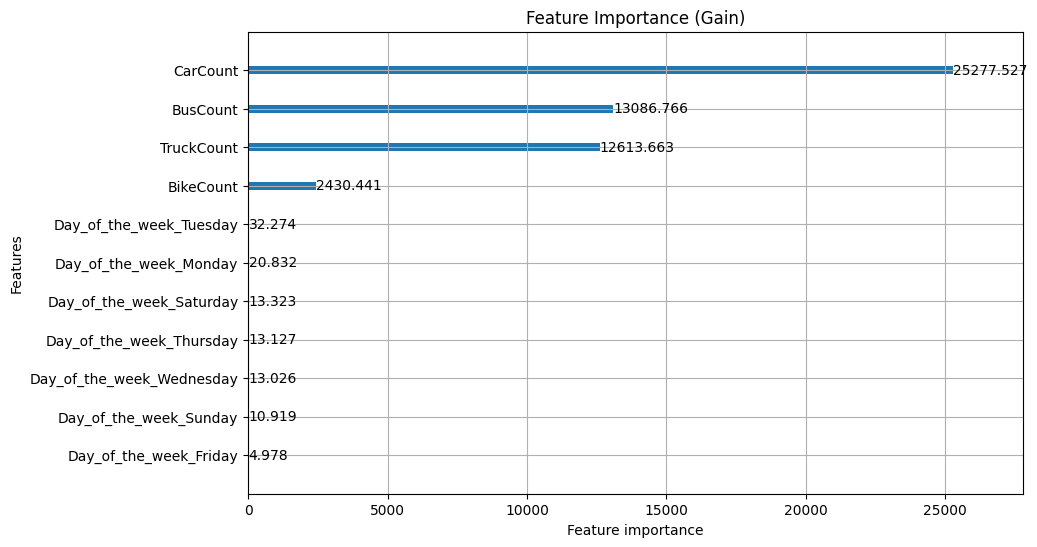

In [140]:
# 학습된 모델의 특성 중요도를 시각화하는 코드
lgb.plot_importance(lgb_model, max_num_features=15, importance_type='gain', figsize=(10,6))
plt.title('Feature Importance (Gain)')
plt.show()

In [141]:
# 검증 데이터 셋에 대한 예측 정확도를 출력하는 코드
from sklearn.metrics import classification_report, accuracy_score

print(f"Accuracy: {accuracy_score(y_val, y_pred):.4f}\n")

Accuracy: 0.9689



In [142]:
# 라이브러리 임포트하기
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [143]:
# 혼동행열 생성
cm = confusion_matrix(y_val, y_pred)

class_names = sorted(y.unique())

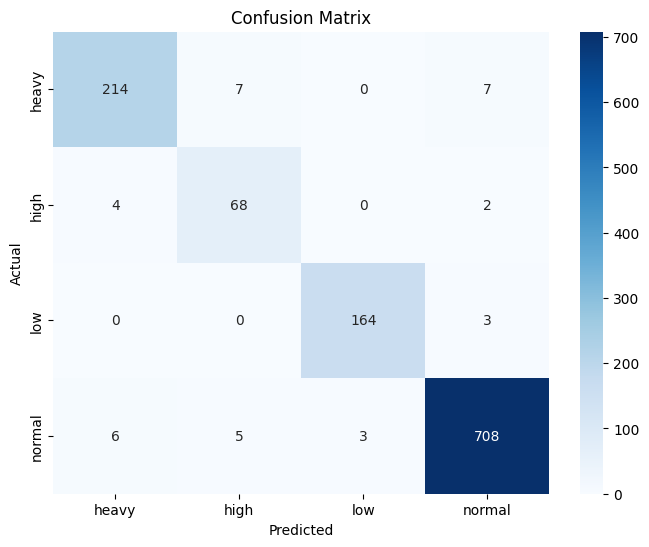

In [144]:
# 혼동행열을 시각화해서 성능을 보여주는 코드
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# XGBoost/LightGBM 성능 비교

In [145]:
# 관련 라이브러리 임포트
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [146]:
# 검증 데이터를 가지고 XGBoost/LightGBM 모델 예측하는 코드
y_pred_xgb = xgb_model.predict(X_val)

y_pred_lgb_proba = lgb_model.predict(X_val)
y_pred_lgb = y_pred_lgb_proba.argmax(axis=1)

In [147]:
# XGBoost/LightGBM 모델 성능 비교
print("=== XGBoost 성능 ===")
print(f"Accuracy: {accuracy_score(y_val, y_pred_xgb):.4f}")
print(classification_report(y_val, y_pred_xgb, target_names=le.classes_))

print("=== LightGBM 성능 ===")
print(f"Accuracy: {accuracy_score(y_val, y_pred_lgb):.4f}")
print(classification_report(y_val, y_pred_lgb, target_names=le.classes_))

=== XGBoost 성능 ===
Accuracy: 0.9656
              precision    recall  f1-score   support

       heavy       0.96      0.95      0.95       228
        high       0.87      0.89      0.88        74
         low       0.95      0.98      0.96       167
      normal       0.98      0.98      0.98       722

    accuracy                           0.97      1191
   macro avg       0.94      0.95      0.94      1191
weighted avg       0.97      0.97      0.97      1191

=== LightGBM 성능 ===
Accuracy: 0.9689
              precision    recall  f1-score   support

       heavy       0.96      0.94      0.95       228
        high       0.85      0.92      0.88        74
         low       0.98      0.98      0.98       167
      normal       0.98      0.98      0.98       722

    accuracy                           0.97      1191
   macro avg       0.94      0.96      0.95      1191
weighted avg       0.97      0.97      0.97      1191



# Prophet 모델 구현하기

In [148]:
from prophet import Prophet
import matplotlib.pyplot as plt

In [149]:
df_prophet = traffic_2_30min[['Datetime', 'Total']].rename(columns={
    'Datetime': 'ds',
    'Total': 'y'
})

In [150]:
# 결측치 제거 (예측 실패 방지)
df_prophet.dropna(subset=['ds', 'y'], inplace=True)

In [151]:
# Prophet 모델 초기화 (일일 seasonality은 시간대별 패턴용, 주간도 포함)
model = Prophet(daily_seasonality=True, weekly_seasonality=True)

In [152]:
# 모델 학습
model.fit(df_prophet)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmph04blipj/84gtymru.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmph04blipj/nyre61xy.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=54040', 'data', 'file=/tmp/tmph04blipj/84gtymru.json', 'init=/tmp/tmph04blipj/nyre61xy.json', 'output', 'file=/tmp/tmph04blipj/prophet_model9g07z82_/prophet_model-20250602011745.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:17:45 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:17:45 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [153]:
# 예측할 기간 생성 (예: 7일 = 30분 단위로 48*7 = 336 스텝)
future = model.make_future_dataframe(periods=336, freq='30min')

In [154]:
# 예측 수행
forecast = model.predict(future)

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44368 (\N{HANGUL SYLLABLE GYO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 53685 (\N{HANGUL SYLLABLE TONG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 54844 (\N{HANGUL SYLLABLE HON}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51105 (\N{HANGUL SYLLABLE JAB}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 46020 (\N{HANGUL SYLLABLE DO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/

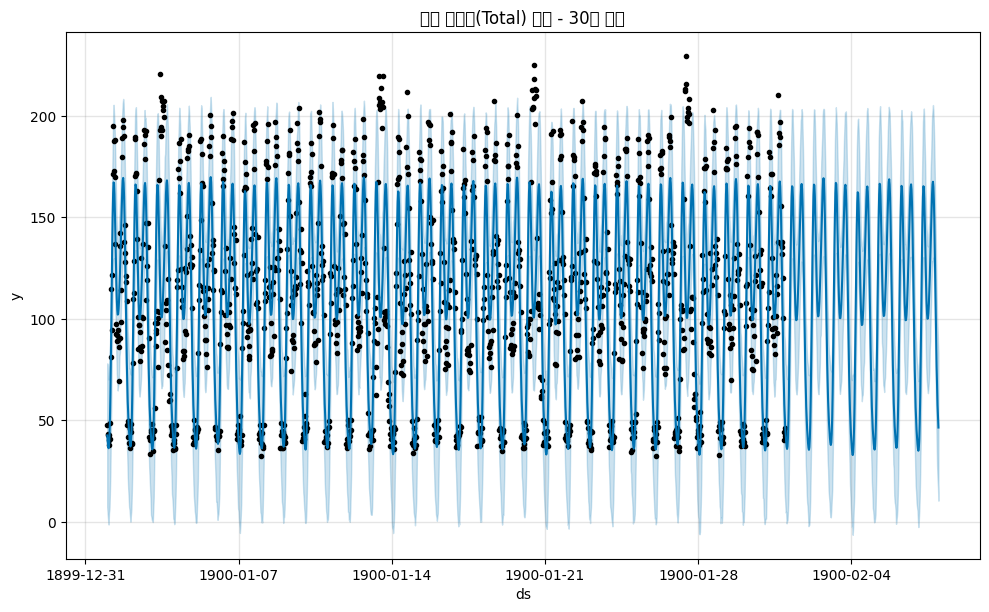

In [155]:
# 예측 결과 시각화
model.plot(forecast)
plt.title('교통 혼잡도(Total) 예측 - 30분 단위')
plt.show()

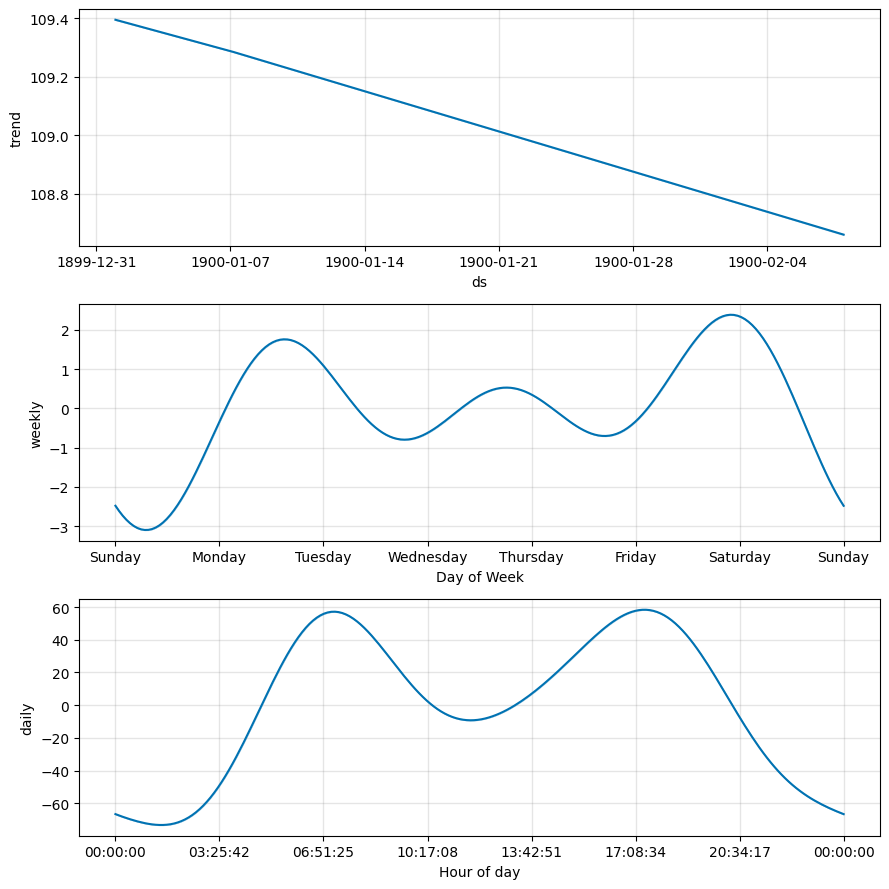

In [156]:
# 구성 요소별 시각화 (추세, 일간/주간 패턴 등)
model.plot_components(forecast)
plt.show()

In [157]:
# 예측 결과에서 실제 데이터 기간만 필터링
# 예측값 중 실제 데이터와 겹치는 구간을 기준으로 평가
forecast_eval = forecast[['ds', 'yhat']].set_index('ds')
actual_eval = df_prophet.set_index('ds')

# 공통 기간만 남기기
df_eval = actual_eval.join(forecast_eval, how='inner')

# 지표 계산
y_true = df_eval['y']
y_pred = df_eval['yhat']

mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_true, y_pred)

print("Prophet 예측 성능 평가")
print(f"Mean Absolute Error (MAE) : {mae:.2f}")
print(f"Mean Squared Error (MSE)  : {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R² Score                  : {r2:.4f}")

Prophet 예측 성능 평가
Mean Absolute Error (MAE) : 20.36
Mean Squared Error (MSE)  : 813.20
Root Mean Squared Error (RMSE): 28.52
R² Score                  : 0.6949


# RandomForest 모델 구현하기

In [158]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [159]:
# 예측 대상 변수 (y)와 특성 (X) 지정
target_col = 'Total'
feature_cols = [col for col in traffic_2_30min.columns if col not in ['Datetime', target_col, 'weekday', 'traffic_level']]

X = traffic_2_30min[feature_cols]
y = traffic_2_30min[target_col]

In [160]:
# 훈련/테스트 데이터 나누기 (8:2 비율)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [161]:
# 랜덤 포레스트 회귀 모델 생성 및 학습
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [162]:
# 예측
y_pred = model.predict(X_test)

In [163]:
# 성능 평가
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse:.2f}')
print(f'R2 Score: {r2:.4f}')

Mean Squared Error: 9.44
R2 Score: 0.9965


<ipython-input-164-15d16439f74d>:11: UserWarning: Glyph 50696 (\N{HANGUL SYLLABLE YE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-164-15d16439f74d>:11: UserWarning: Glyph 52769 (\N{HANGUL SYLLABLE CEUG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-164-15d16439f74d>:11: UserWarning: Glyph 49892 (\N{HANGUL SYLLABLE SIL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-164-15d16439f74d>:11: UserWarning: Glyph 51228 (\N{HANGUL SYLLABLE JE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 50696 (\N{HANGUL SYLLABLE YE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 52769 (\N{HANGUL SYLLABLE CEUG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-

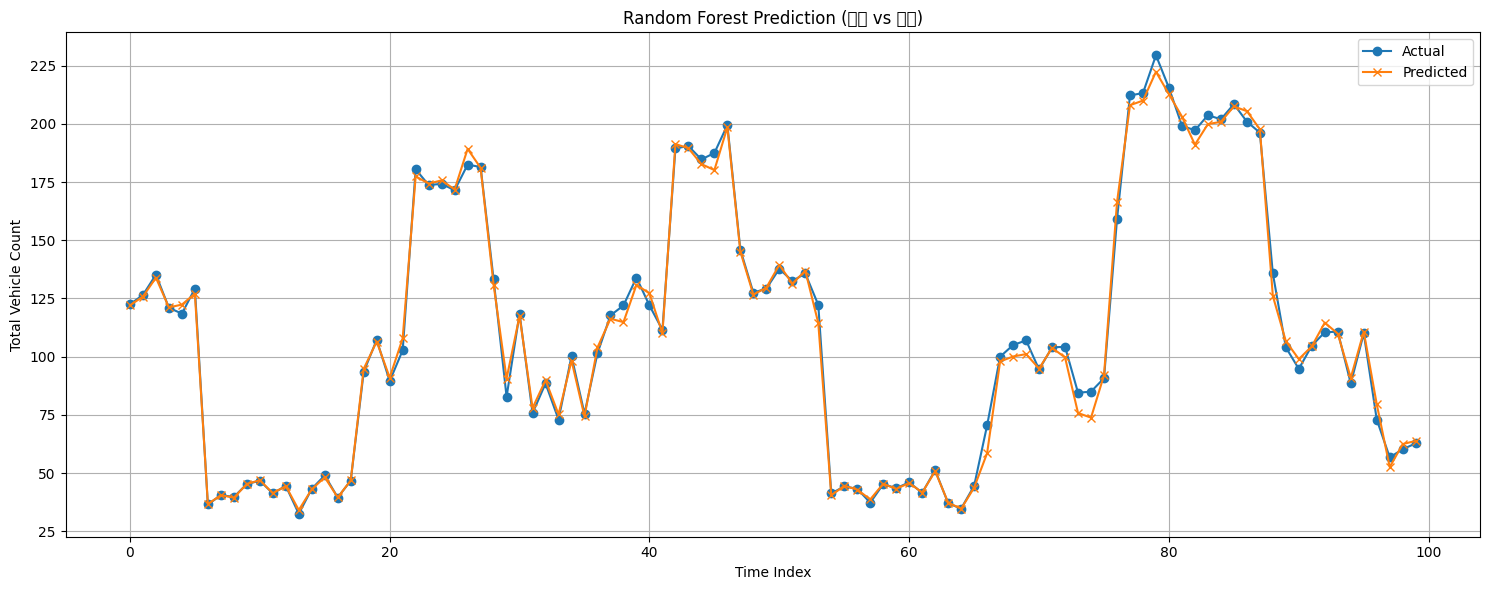

In [164]:
# 실제 vs 예측 시각화

plt.figure(figsize=(15, 6))
plt.plot(y_test.values[:100], label='Actual', marker='o')
plt.plot(y_pred[:100], label='Predicted', marker='x')
plt.title('Random Forest Prediction (예측 vs 실제)')
plt.xlabel('Time Index')
plt.ylabel('Total Vehicle Count')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [165]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# MAE, MSE, RMSE, R² 계산
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)  # RMSE 계산
r2 = r2_score(y_test, y_pred)

print("RandomForest 회귀 모델 성능")
print(f"Mean Absolute Error (MAE) : {mae:.2f}")
print(f"Mean Squared Error (MSE)  : {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R² Score                  : {r2:.4f}")

RandomForest 회귀 모델 성능
Mean Absolute Error (MAE) : 2.12
Mean Squared Error (MSE)  : 9.44
Root Mean Squared Error (RMSE): 3.07
R² Score                  : 0.9965


# Prophet/RandomForest 모델 성능 비교

In [166]:
print("Prophet 예측 성능 평가")
print(f"Mean Absolute Error (MAE) : {mae:.2f}")
print(f"Mean Squared Error (MSE)  : {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R² Score                  : {r2:.4f}\n")

print("RandomForest 회귀 모델 성능")
print(f"Mean Absolute Error (MAE) : {mae:.2f}")
print(f"Mean Squared Error (MSE)  : {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R² Score                  : {r2:.4f}")

Prophet 예측 성능 평가
Mean Absolute Error (MAE) : 2.12
Mean Squared Error (MSE)  : 9.44
Root Mean Squared Error (RMSE): 3.07
R² Score                  : 0.9965

RandomForest 회귀 모델 성능
Mean Absolute Error (MAE) : 2.12
Mean Squared Error (MSE)  : 9.44
Root Mean Squared Error (RMSE): 3.07
R² Score                  : 0.9965
